# Content

- The objective of this notebook is to explain to the reader how to discover Differential Causal Rules in a Knowledge Graph.
- This tutorial is a follow up of the tutorial 1 : Tutorial1_Creating_Synthethic_Instances.ipynb

Various functions used to mine DCR are presented, including :
- getting the distance threshold
- build pairs of instances
- compute the metric of a DCR

# Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import math
import random
import copy
import sys
import itertools
import time
import uuid
from scipy.spatial import distance
import pickle

In [2]:
import ampligraph
import tensorflow as tf

if ampligraph.__version__ == '1.4.0':
    print("AmpliGraph version OK")
if tf.__version__ == '1.15.2':
    print("TensorFlow version OK")
    
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.evaluation import evaluate_performance
from ampligraph.latent_features.models import ConvE

AmpliGraph version OK
TensorFlow version OK


In [3]:
sys.path.append('../similarity_search')
from pairs_mining import *
from threshold_estimation import *
from distance_threshold_estimation import *
sys.path.append('../dcr_discovery')
from metrics import *

# Data Import

In [4]:
# getting the data
directory_path = '../mining_all_rules/'
file_name = 'X_with_truncated.csv'
df_ = pd.read_csv(directory_path+file_name,sep=';', header=None)
X = df_.to_numpy()

In [5]:
# keeping track of the synthetic intances
with open(directory_path+'list_target_class_instances.pkl', 'rb') as f1:
    list_target_class_instances = pickle.load(f1)

with open(directory_path+'dic_truncated_pairs.pkl', 'rb') as f2:
    dic_truncated_pairs = pickle.load(f2)

# Parameters

In [6]:
# target class type and paths of interest
PATH_TYPE = '22-rdf-syntax-ns#type'
TYPE_TARGET_CLASS = 'Person'

PATHS_TREATMENT = ['sex']
PATH_DIET = ['hasCurrentDiet']
PATH_IDEAL_DIET = ['hasIdealDiet']
path_flesh_diet = PATH_DIET + ['fleshIntensity']
path_flesh_ideal_diet = PATH_IDEAL_DIET + ['fleshIntensity']
MAX_DEGREE_DIFFERENCE = max([len(i) for i in list(dic_truncated_pairs.keys())])

# training parameters
EPOCHS = 130
TEST_SET_PROPORTION = 0.1

# rule parameter
STAT_PARAM = 1.64

# Training a Model

In [7]:
print('Analysing treatment : ',PATHS_TREATMENT)

Analysing treatment :  ['sex']


In [8]:
# some treatment and outcome properties are to be removed in order to match instances independently of their values on these paths
list_of_paths_to_remove = [PATH_TYPE,PATH_DIET[-1],PATH_IDEAL_DIET[-1],PATHS_TREATMENT[-1]]

In [9]:
X_training = np.array([x for x in X if x[1] not in list_of_paths_to_remove])
test_size = round(TEST_SET_PROPORTION*len(X_training))
X_train, X_test = train_test_split_no_unseen(X_training, test_size=test_size)

In [10]:
model = ConvE(
    batches_count=100,
    seed=0,
    epochs=EPOCHS,
    k=150,
    eta=5,
    optimizer='adam',
    optimizer_params={'lr':1e-3},
    loss='bce',
    regularizer='LP',
    regularizer_params={'p':3, 'lambda':1e-5},
    verbose=True
)
positives_filter = X_training

In [11]:
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(
    X_train,
    early_stopping = False
)

Average Loss:   1.192432: 100%|██████████| 130/130 [1:13:26<00:00, 33.90s/epoch]


In [12]:
ranks = evaluate_performance(
    X_test,
    model=model,
    filter_triples=positives_filter,
    filter_unseen=True,
    use_default_protocol=True,
    verbose=True
)

model_performances = {}
mrr = mrr_score(ranks)
model_performances['mrr'] = mrr
hits_1 = hits_at_n_score(ranks, n=1)
model_performances['hits_1'] = hits_1
hits_3 = hits_at_n_score(ranks, n=3)
model_performances['hits_3'] = hits_3
hits_10 = hits_at_n_score(ranks, n=10)
model_performances['hits_10'] = hits_10
model_performances = {key:[value] for key,value in model_performances.items()}
df_model_performances = pd.DataFrame.from_dict(model_performances)

df_model_performances

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.
Mapping set data: test
Mapping set data: filter


100%|██████████| 22/22 [00:21<00:00,  1.02batch/s]


,mrr,hits_1,hits_3,hits_10
0,0.291212,0.209724,0.335918,0.442184


# Checking the distance with all number of differences

<div class="alert alert-success">
    <b>Note :</b>
    The number of differences can be defined before training the model and creating the matches. However, we show the evolution of the distance with a range of number of differences for the purpose of this tutorial. The obtained figures are presented in the paper.
</div>

In [13]:
# evolution distance with truncated degree
dic_distance_per_degree = {i:[] for i in range(0,MAX_DEGREE_DIFFERENCE+1)}
for key,value in dic_truncated_pairs.items():
    for pair in value:
        distance_ = get_distance_for_pair(tuple(pair),model)
        dic_distance_per_degree[len(key)].append(distance_)

In [14]:
columns = ['number_differences','distance']
df_ = pd.DataFrame(columns=columns)

In [15]:
for number_differences,list_distance in dic_distance_per_degree.items():
    for d in list_distance:
        dic_to_add = {}
        dic_to_add['number_differences'] = number_differences
        dic_to_add['distance'] = d
        df_ = df_.append(dic_to_add,ignore_index=True)

WARNING - No handles with labels found to put in legend.


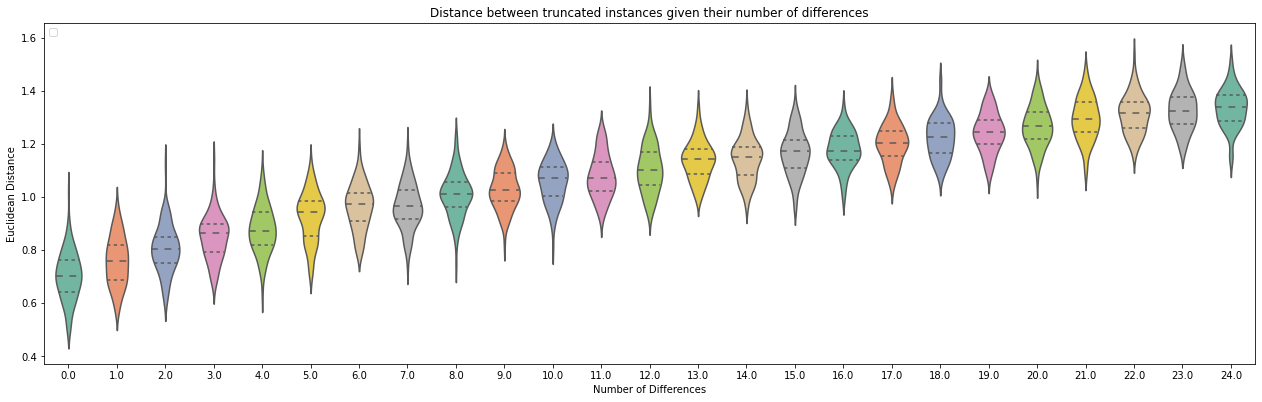

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(21.7, 6.27)
ax = sns.violinplot(
    x="number_differences",
    y="distance",
    data=df_,
    palette="Set2",
    inner="quartile",
    split=True,
    width=0.7,
    gridsize=100
)

ax.set(xlabel='Number of Differences', ylabel='Euclidean Distance',title='Distance between truncated instances given their number of differences')
ax.legend(loc='upper left')

# Creating the pairs of instances

In [17]:
# building the similarity matrix
mode = 'treatment_sort'
treatment_values = list(np.unique([x[2] for x in X if x[1]==PATHS_TREATMENT[-1]]))

In [19]:
treatment_combinaison = list(itertools.combinations(treatment_values,2))

In [21]:
treatment0 = treatment_combinaison[0][0]
treatment1 = treatment_combinaison[0][1]

In [24]:
# getting the instances with the treatment value - be careful to not select synthetic instances
instances_t0 = list(np.unique([x[0] for x in X if x[1]==PATHS_TREATMENT[-1] and x[2]==treatment0]))
instances_t1 = list(np.unique([x[0] for x in X if x[1]==PATHS_TREATMENT[-1] and x[2]==treatment1]))
instances_t0 = [i for i in instances_t0 if i in list_target_class_instances]
instances_t1 = [i for i in instances_t1 if i in list_target_class_instances]

In [25]:
print('Number of instances for treatment0 : ',len(instances_t0))
print('Number of instances for treatment1 : ',len(instances_t1))

Number of instances for treatment0 :  770
Number of instances for treatment1 :  944


In [26]:
if len(instances_t0) > 1 and len(instances_t1) > 1:
    df_similarity,df_to_numpy = get_matrix_similarity_pairs(
        model,
        list_target_class_instances,
        mode=mode,
        instances_t0=instances_t0,
        instances_t1=instances_t1
    )

In [27]:
# the maximum number of pairs that can be built is the minimum number of instances of one treatment value
number_max_of_pairs = min(df_similarity.shape)

In [28]:
print('The maximum number of pairs that can be build is : ',number_max_of_pairs)

The maximum number of pairs that can be build is :  770


<div class="alert alert-success">
    <b>Note 1 :</b>
    Given the similarity matrix that has been build, pairs can be mined depending on the distance threshold that is used.
</div>

<div class="alert alert-success">
    <b>Note 2 :</b>
    For a numerical treatment, the similarity matrix is squared and each instance having a value defined for the treatment is both in a column and a row. During the pairs mining process, the similarity matrix is therefore to be modified 2 times per pair [(i1:column,i2:row) and (i2:column,i1:row)], while it is only modified once when mining a DCR on a categorical treatment.
</div>

# Getting the Effect for each distance threshold

<div class="alert alert-success">
    <b>Note :</b>
    Similarly, we present a range of effects depending on the number of differences for the purpose of this tutorial.
</div>

In [29]:
columns = [
    'Degree','Distance_Threshold','Number_Pairs',
    'Percentage_Possible_Pairs_Created','Treatment',
    't0','t1','causal_metric','causal_metric_IC','T_O',
    'T_not_O','same_O'
]
df_rules = pd.DataFrame(columns=columns)

In [33]:
for degree in range(len(dic_distance_per_degree)):
    print('Degree studied : ',degree)
    # obtaining the distance threshold and the resulting pairs
    distance_threshold = get_distance_for_degree(dic_distance_per_degree,degree)
    pairs_similar_instances = get_pairs_from_matrix_and_threshold(df_similarity,distance_threshold)

    row_study = {}
    row_study['Degree'] = degree
    row_study['Distance_Threshold'] = distance_threshold
    row_study['Number_Pairs'] = len(pairs_similar_instances)
    row_study['Percentage_Possible_Pairs_Created'] = len(pairs_similar_instances)*100/(min(df_similarity.shape))
    row_study['Treatment'] = PATHS_TREATMENT
    row_study['t0'] = treatment0
    row_study['t1'] = treatment1
    
    # computing the metric given the pairs that were obtained : getting outcome of the instances
    causal_metric, causal_metric_IC,T_O,T_not_O,same_O  = compute_metric_vitamin(
        pairs_similar_instances=pairs_similar_instances,
        X=X,
        PATH_TREATMENT=PATHS_TREATMENT,
        PATH_DIET=path_flesh_diet,
        PATH_IDEAL_DIET=path_flesh_ideal_diet,
        t0=treatment0,
        t1=treatment1,
        stat_param=STAT_PARAM
        )

    row_study['causal_metric'] = causal_metric
    row_study['causal_metric_IC'] = causal_metric_IC
    row_study['T_O'] = T_O
    row_study['T_not_O'] = T_not_O
    row_study['same_O'] = same_O

    df_rules = df_rules.append(row_study,ignore_index=True)

Degree studied :  0
Degree studied :  1
Degree studied :  2
Degree studied :  3
Degree studied :  4
Degree studied :  5
Degree studied :  6
Degree studied :  7
Degree studied :  8
Degree studied :  9
Degree studied :  10
Degree studied :  11
Degree studied :  12
Degree studied :  13
Degree studied :  14
Degree studied :  15
Degree studied :  16
Degree studied :  17
Degree studied :  18
Degree studied :  19
Degree studied :  20
Degree studied :  21
Degree studied :  22
Degree studied :  23
Degree studied :  24
